In [66]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
import matplotlib

In [68]:
import os
import logging
import argparse
import glob
import json

import numpy as np
from matplotlib.ticker import StrMethodFormatter

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
import pandas as pd
from astropy.table import Table  # for NSA
from astropy import units as u
from sklearn.metrics import confusion_matrix, roc_curve
from PIL import Image
from scipy.stats import binom
from IPython.display import display, Markdown

from shared_astro_utils import astropy_utils, matching_utils
from zoobot.estimators import make_predictions, bayesian_estimator_funcs
from zoobot.tfrecord import read_tfrecord
from zoobot.uncertainty import discrete_coverage
from zoobot.estimators import input_utils, losses
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline, run_estimator_config


In [69]:
os.chdir('/home/walml/repos/zoobot')

In [70]:
# label_cols = [
#     'smooth-or-featured_smooth',
#     'smooth-or-featured_featured-or-disk',
#     'has-spiral-arms_yes',
#     'has-spiral-arms_no',
# #     'spiral-winding_tight',
# #     'spiral-winding_medium',
# #     'spiral-winding_loose',
#     'bar_strong',
#     'bar_weak',
#     'bar_no',
#     'bulge-size_dominant',
#     'bulge-size_large',
#     'bulge-size_moderate',
#     'bulge-size_small',
#     'bulge-size_none'
# ]

# questions = [
#     'smooth-or-featured',
#     'has-spiral-arms',
# #     'spiral-winding',
#     'bar',
#     'bulge-size'
# ]

# schema = losses.Schema(label_cols, questions)
# schema.questions

In [71]:
label_cols = [
    'smooth-or-featured_smooth',
    'smooth-or-featured_featured-or-disk',
    'has-spiral-arms_yes',
    'has-spiral-arms_no',
#     'spiral-winding_tight',
#     'spiral-winding_medium',
#     'spiral-winding_loose',
    'bar_strong',
    'bar_weak',
    'bar_no',
    'bulge-size_dominant',
    'bulge-size_large',
    'bulge-size_moderate',
    'bulge-size_small',
    'bulge-size_none'
]

questions = [
    'smooth-or-featured',
    'has-spiral-arms',
#     'spiral-winding',
    'bar',
    'bulge-size'
]

schema = losses.Schema(label_cols, questions, version='decals')
schema.questions

{smooth-or-featured, indices 0 to 1, asked after None: (0, 1), has-spiral-arms, indices 2 to 3, asked after <zoobot.estimators.losses.Answer object at 0x7f1710aed7d0>: (2, 3), bar, indices 4 to 6, asked after <zoobot.estimators.losses.Answer object at 0x7f1710aed7d0>: (4, 6), bulge-size, indices 7 to 11, asked after <zoobot.estimators.losses.Answer object at 0x7f1710aed7d0>: (7, 11)}


[smooth-or-featured, indices 0 to 1, asked after None,
 has-spiral-arms, indices 2 to 3, asked after <zoobot.estimators.losses.Answer object at 0x7f1710aed7d0>,
 bar, indices 4 to 6, asked after <zoobot.estimators.losses.Answer object at 0x7f1710aed7d0>,
 bulge-size, indices 7 to 11, asked after <zoobot.estimators.losses.Answer object at 0x7f1710aed7d0>]

In [72]:
# df = pd.read_csv('temp/master_256_predictions_2500init.csv')
# df = pd.read_csv('temp/smooth_or_featured_labelled_latest.csv')
df = pd.read_csv('temp/effnet_latest.csv')

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (109) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [73]:
df.head()

Unnamed: 0              iauname  nsa_id  ra_subject  dec_subject  \
0        3007  J114311.80-005945.4    6394  175.799176    -0.995977   
1        3013  J114234.93-010223.3    6409  175.645594    -1.039803   
2        3014  J114158.56-011334.4    6411  175.494016    -1.226278   
3        3015  J114221.35-011301.2    6414  175.588955    -1.217026   
4        3021  J114100.38-005812.6    6430  175.251666    -0.970073   

   petrotheta  petroth50  petroth90  redshift  \
0    4.769891   2.403030   5.330101  0.093060   
1    8.798181   3.986430   9.777639  0.108958   
2    9.472872   3.862174  10.472028  0.107790   
3    6.101641   2.886945   7.018666  0.076975   
4    8.128530   3.944574   9.274990  0.028913   

                                      local_fits_loc  ...  \
0  /Volumes/alpha/decals/fits_native/dr5/J114/J11...  ...   
1  /Volumes/alpha/decals/fits_native/dr5/J114/J11...  ...   
2  /Volumes/alpha/decals/fits_native/dr5/J114/J11...  ...   
3  /Volumes/alpha/decals/fits_native/dr5/J114/J11...  ...   
4  /Volumes/alpha/decals/fits_native/dr5/J114/J11...  ...   

                      bulge-size_dominant_prediction  \
0  [0.04262910038232803, 0.016658904030919075, 0....   
1  [0.007415104657411575, 0.007838904857635498, 0...   
2  [0.008610561490058899, 0.0071463510394096375, ...   
3  [0.021249478682875633, 0.018415333703160286, 0...   
4  [0.00965325441211462, 0.017385421320796013, 0....   

   bulge-size_dominant_prediction_mean  \
0                             0.023788   
1                             0.006908   
2                             0.008307   
3                             0.019684   
4                             0.012718   

                         bulge-size_large_prediction  \
0  [0.15324892103672028, 0.08992495387792587, 0.1...   
1  [0.03921530023217201, 0.04610105976462364, 0.0...   
2  [0.0454450361430645, 0.04326174035668373, 0.05...   
3  [0.10940727591514587, 0.1085921972990036, 0.10...   
4  [0.03677285462617874, 0.0501408725976944, 0.04...   

   bulge-size_large_prediction_mean  \
0                          0.119022   
1                          0.044864   
2                          0.041897   
3                          0.106024   
4                          0.050768   

                      bulge-size_moderate_prediction  \
0  [0.19541844725608826, 0.2901086211204529, 0.29...   
1  [0.41776421666145325, 0.4635247588157654, 0.49...   
2  [0.4529438018798828, 0.46400731801986694, 0.35...   
3  [0.5854149460792542, 0.5571314096450806, 0.584...   
4  [0.3044124245643616, 0.17468252778053284, 0.31...   

   bulge-size_moderate_prediction_mean  \
0                             0.247091   
1                             0.492537   
2                             0.428557   
3                             0.566463   
4                             0.263830   

                         bulge-size_small_prediction  \
0  [0.20418624579906464, 0.3926066756248474, 0.25...   
1  [0.5211817622184753, 0.4722156524658203, 0.435...   
2  [0.4478592872619629, 0.44699808955192566, 0.46...   
3  [0.23216891288757324, 0.27923446893692017, 0.2...   
4  [0.4528931975364685, 0.24049556255340576, 0.41...   

   bulge-size_small_prediction_mean  \
0                          0.302042   
1                          0.444397   
2                          0.484512   
3                          0.250000   
4                          0.330399   

                          bulge-size_none_prediction  \
0  [0.4045172929763794, 0.2107008546590805, 0.263...   
1  [0.014423578977584839, 0.010319691151380539, 0...   
2  [0.045141324400901794, 0.03858647122979164, 0....   
3  [0.05175939202308655, 0.03662663325667381, 0.0...   
4  [0.19626830518245697, 0.5172955989837646, 0.20...   

   bulge-size_none_prediction_mean  
0                         0.308057  
1                         0.011294  
2                         0.036727  
3                         0.057829  
4                         0.342286  

[5 rows x 135 columns]

In [74]:
df.columns.values

array(['Unnamed: 0', 'iauname', 'nsa_id', 'ra_subject', 'dec_subject',
       'petrotheta', 'petroth50', 'petroth90', 'redshift',
       'local_fits_loc', 'local_png_loc', 'fits_ready', 'fits_filled',
       'png_ready', 'best_match', 'sky_separation', 'nsa_version', 'mag',
       'ra', 'dec', 'file_loc', 'subject_id', 'bar_no', 'bar_strong',
       'bar_weak', 'bulge-size_dominant', 'bulge-size_large',
       'bulge-size_moderate', 'bulge-size_none', 'bulge-size_small',
       'disk-edge-on_no', 'disk-edge-on_yes', 'edge-on-bulge_boxy',
       'edge-on-bulge_none', 'edge-on-bulge_rounded',
       'has-spiral-arms_no', 'has-spiral-arms_yes',
       'how-rounded_cigar-shaped', 'how-rounded_in-between',
       'how-rounded_round', 'merging_both-v1',
       'merging_major-disturbance', 'merging_merger',
       'merging_minor-disturbance', 'merging_neither-v1', 'merging_none',
       'merging_tidal-debris-v1', 'smooth-or-featured_artifact',
       'smooth-or-featured_featured-or-disk', 'sm

In [75]:
for col in label_cols:
    prediction_col = col + '_prediction'
    df[prediction_col] = df[prediction_col].apply(json.loads)

In [76]:
# copied from trust_the_model.ipynb
def show_galaxies(df, scale=3, nrows=3, ncols=3):
    fig = plt.gcf()

    plt.figure(figsize=(scale * nrows, scale * ncols * 1.025))
    gs1 = gridspec.GridSpec(nrows, ncols)
    gs1.update(wspace=0.0, hspace=0.0)
    galaxy_n = 0
    for row_n in range(nrows):
        for col_n in range(ncols):
            galaxy = df.iloc[galaxy_n]
            image = Image.open(galaxy['file_loc'])
            ax = plt.subplot(gs1[row_n, col_n])
            ax.imshow(image)
#             ax.text(10, 20, 'Smooth = {:.2f}'.format(galaxy['smooth-or-featured_smooth_fraction']), fontsize=12, color='r')
#             ax.text(10, 50, r'$\rho = {:.2f}$, Var ${:.3f}$'.format(galaxy['median_prediction'], 3*galaxy['predictions_var']), fontsize=12, color='r')
#             ax.text(10, 80, '$L = {:.2f}$'.format(galaxy['bcnn_likelihood']), fontsize=12, color='r')
            ax.axis('off')
            galaxy_n += 1
#     print('Mean L: {:.2f}'.format(df[:nrows * ncols]['bcnn_likelihood'].mean()))
    fig = plt.gcf()
#     fig.tight_layout()
    return fig


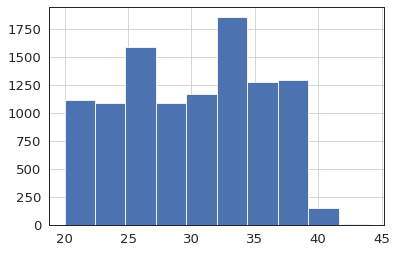

In [77]:
df['smooth-or-featured_featured-or-disk'].hist()

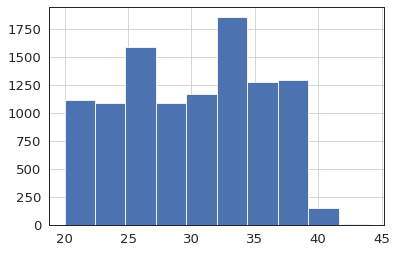

In [78]:
df['smooth-or-featured_featured-or-disk'].hist()

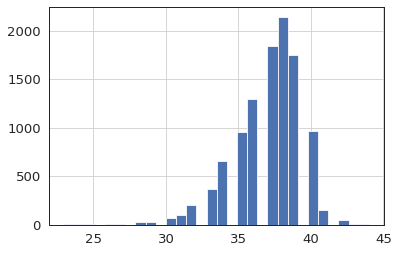

In [79]:
(df['smooth-or-featured_featured-or-disk'] + df['smooth-or-featured_smooth']).hist(bins=30)

(0.0, 1.0)

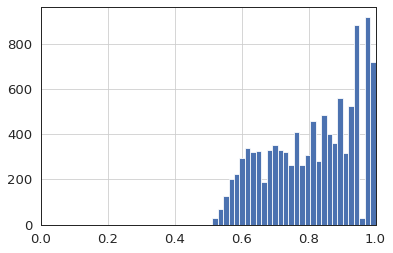

In [80]:
(df['smooth-or-featured_featured-or-disk'] / (df['smooth-or-featured_featured-or-disk'] + df['smooth-or-featured_smooth'])).hist(bins=30)
plt.xlim(0., 1.)

(0.0, 1.0)

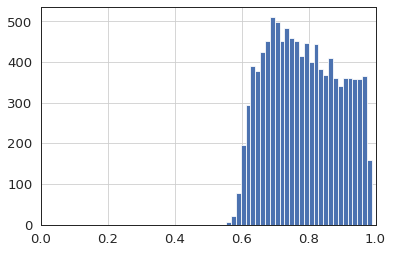

In [81]:
df['smooth-or-featured_featured-or-disk_prediction_mean'].hist(bins=30)
plt.xlim(0., 1.)

<Figure size 432x288 with 0 Axes>

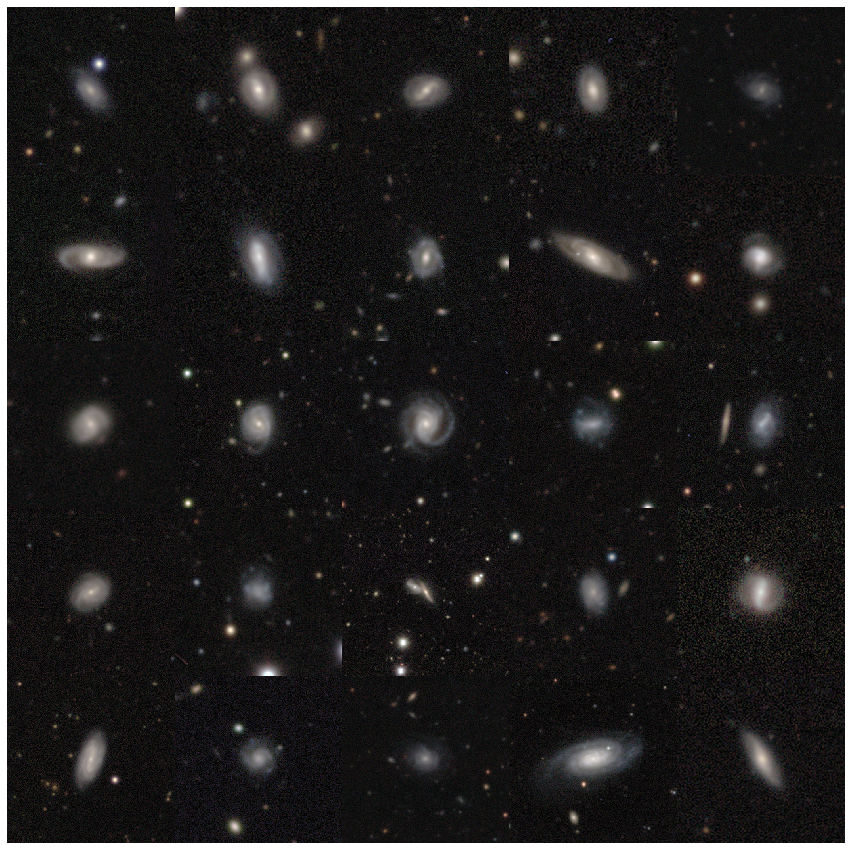

In [82]:
_ = show_galaxies(df.sample(100), ncols=5, nrows=5)

<Figure size 432x288 with 0 Axes>

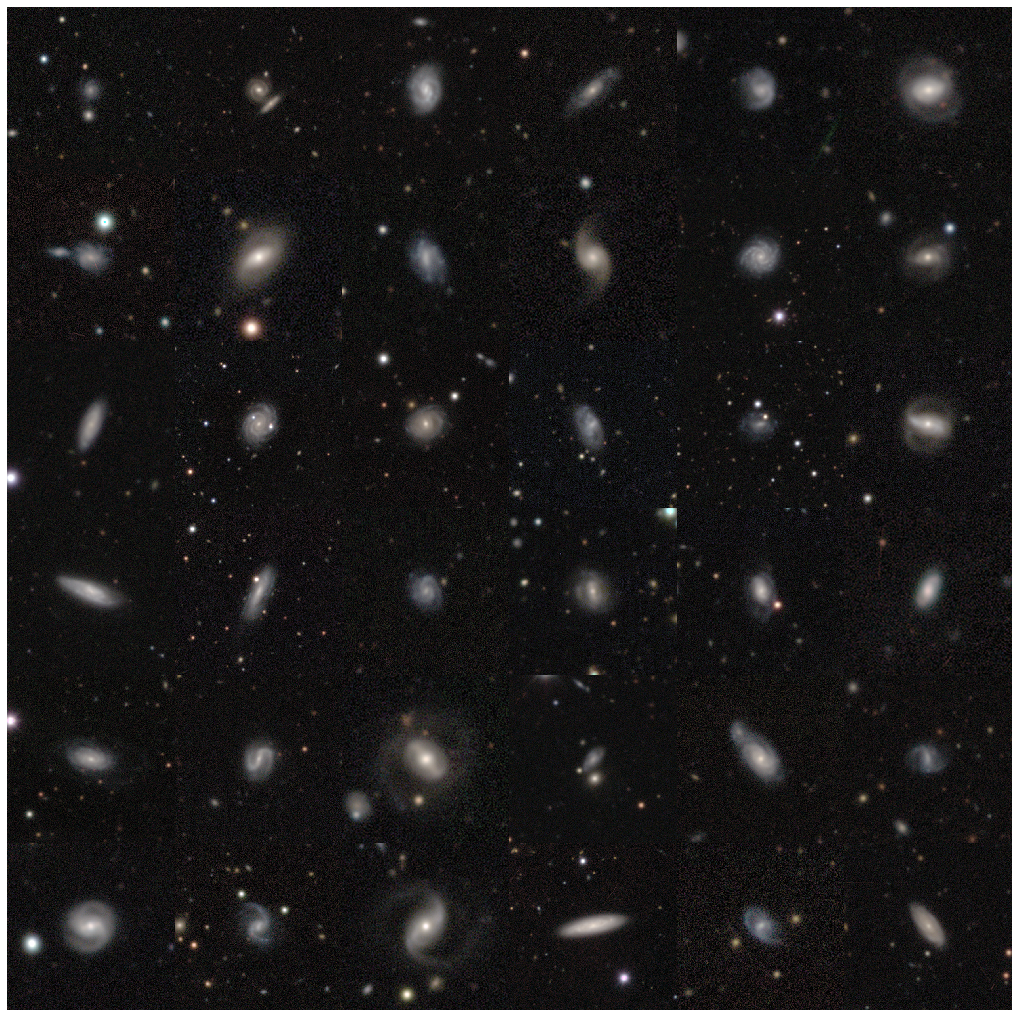

In [83]:
_ = show_galaxies(df[df['smooth-or-featured_featured-or-disk_prediction_mean'] > 0.45].sample(100), ncols=6, nrows=6)

In [84]:
df.columns.values

array(['Unnamed: 0', 'iauname', 'nsa_id', 'ra_subject', 'dec_subject',
       'petrotheta', 'petroth50', 'petroth90', 'redshift',
       'local_fits_loc', 'local_png_loc', 'fits_ready', 'fits_filled',
       'png_ready', 'best_match', 'sky_separation', 'nsa_version', 'mag',
       'ra', 'dec', 'file_loc', 'subject_id', 'bar_no', 'bar_strong',
       'bar_weak', 'bulge-size_dominant', 'bulge-size_large',
       'bulge-size_moderate', 'bulge-size_none', 'bulge-size_small',
       'disk-edge-on_no', 'disk-edge-on_yes', 'edge-on-bulge_boxy',
       'edge-on-bulge_none', 'edge-on-bulge_rounded',
       'has-spiral-arms_no', 'has-spiral-arms_yes',
       'how-rounded_cigar-shaped', 'how-rounded_in-between',
       'how-rounded_round', 'merging_both-v1',
       'merging_major-disturbance', 'merging_merger',
       'merging_minor-disturbance', 'merging_neither-v1', 'merging_none',
       'merging_tidal-debris-v1', 'smooth-or-featured_artifact',
       'smooth-or-featured_featured-or-disk', 'sm

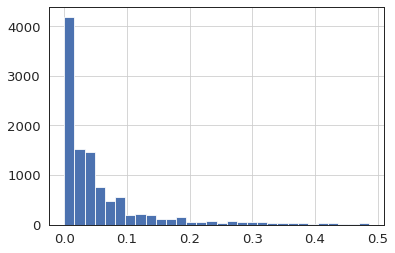

In [85]:
feat = df[df['smooth-or-featured_featured-or-disk_prediction_mean'] > 0.5]
(feat['disk-edge-on_yes'] / feat['smooth-or-featured_featured-or-disk']).hist(bins=30)

In [86]:
b = (feat['disk-edge-on_yes'] / feat['smooth-or-featured_featured-or-disk']) < 0.5
face = feat[b]
edge = feat[~b]

In [87]:
edge

Empty DataFrame
Columns: [Unnamed: 0, iauname, nsa_id, ra_subject, dec_subject, petrotheta, petroth50, petroth90, redshift, local_fits_loc, local_png_loc, fits_ready, fits_filled, png_ready, best_match, sky_separation, nsa_version, mag, ra, dec, file_loc, subject_id, bar_no, bar_strong, bar_weak, bulge-size_dominant, bulge-size_large, bulge-size_moderate, bulge-size_none, bulge-size_small, disk-edge-on_no, disk-edge-on_yes, edge-on-bulge_boxy, edge-on-bulge_none, edge-on-bulge_rounded, has-spiral-arms_no, has-spiral-arms_yes, how-rounded_cigar-shaped, how-rounded_in-between, how-rounded_round, merging_both-v1, merging_major-disturbance, merging_merger, merging_minor-disturbance, merging_neither-v1, merging_none, merging_tidal-debris-v1, smooth-or-featured_artifact, smooth-or-featured_featured-or-disk, smooth-or-featured_smooth, spiral-arm-count_1, spiral-arm-count_2, spiral-arm-count_3, spiral-arm-count_4, spiral-arm-count_cant-tell, spiral-arm-count_more-than-4, spiral-winding_loose, spiral-winding_medium, spiral-winding_tight, smooth-or-featured_total-votes, how-rounded_total-votes, disk-edge-on_total-votes, edge-on-bulge_total-votes, bar_total-votes, has-spiral-arms_total-votes, spiral-winding_total-votes, spiral-arm-count_total-votes, bulge-size_total-votes, merging_total-votes, smooth-or-featured_smooth_fraction, smooth-or-featured_featured-or-disk_fraction, smooth-or-featured_artifact_fraction, how-rounded_round_fraction, how-rounded_in-between_fraction, how-rounded_cigar-shaped_fraction, disk-edge-on_yes_fraction, disk-edge-on_no_fraction, edge-on-bulge_rounded_fraction, edge-on-bulge_boxy_fraction, edge-on-bulge_none_fraction, bar_strong_fraction, bar_weak_fraction, bar_no_fraction, has-spiral-arms_yes_fraction, has-spiral-arms_no_fraction, spiral-winding_tight_fraction, spiral-winding_medium_fraction, spiral-winding_loose_fraction, spiral-arm-count_1_fraction, spiral-arm-count_2_fraction, spiral-arm-count_3_fraction, spiral-arm-count_4_fraction, spiral-arm-count_more-than-4_fraction, spiral-arm-count_cant-tell_fraction, bulge-size_none_fraction, bulge-size_small_fraction, bulge-size_moderate_fraction, bulge-size_large_fraction, bulge-size_dominant_fraction, merging_merger_fraction, ...]
Index: []

[0 rows x 135 columns]

In [88]:
_ = show_galaxies(edge.sample(100), ncols=6, nrows=6)

ValueError: a must be greater than 0 unless no samples are taken

In [ ]:
_ = show_galaxies(face.sample(100), ncols=6, nrows=6)

In [ ]:
# df['disk-edge-on_yes_prediction_mean_dummy'] = df['disk-edge-on_yes'] / df['smooth-or-featured_featured-or-disk']
# df.to_csv('temp/smooth_or_featured_labelled_latest_with_edge.csv', index=False)

In [89]:

def get_single_answer_data(df, answer, n=10):
    samples = np.stack(df[answer.text + '_prediction'][:n])
    labels = df[answer.text][:n].values.astype(int)
    total_votes = df[answer.question.text + '_total-votes'][:n].values.astype(int)
    return samples, labels, total_votes
    

In [90]:
def show_population_stats(samples, labels, total_votes, title):
    # sns.set_context('paper')
    sns.set(font_scale=1.)
    sns.set_style('white')
    alpha = 0.5
    # matplotlib.rcParams.update({'font.size': 50}
    
    mean_samples = samples.mean(axis=-1)
    expected_k = mean_samples * total_votes

    # dummy for bins
    fig, (ax0, ax1) = plt.subplots(nrows=2)
    _, bins_rho, _ = ax0.hist(labels/ total_votes, bins=25, alpha=alpha, label='Actual')
    _, bins_k, _ = ax1.hist(labels, bins=25, alpha=alpha, label='Actual')
    plt.close()

    # now for real
    fig, (ax0, ax1) = plt.subplots(nrows=2)

    _, bins, _ = ax0.hist(mean_samples, bins=bins_rho, alpha=alpha, label='Model')
    ax0.hist(labels/ total_votes, bins=bins_rho, alpha=alpha, label='Actual')
    ax0.set_xlabel(r'Vote Fraction $\rho$')
    ax0.set_ylabel('Galaxies')
    ax0.legend()
    ax0.set_xlim([0., 1.])

    _, bins, _ = ax1.hist(expected_k, bins=bins_k, alpha=alpha, label='Model')
    ax1.hist(labels, bins=bins_k, alpha=alpha, label='Actual')
    ax1.set_xlabel(r'Positive Responses $k$')
    ax1.set_ylabel('Galaxies')
    ax1.legend()
    ax1.set_xlim([0, 40])

    ax0.set_title(title)
    fig.tight_layout()
    return fig
    # fig.savefig(os.path.join(save_dir, 'posterior_over_full_sample.png'))
    # fig.savefig(os.path.join(save_dir, 'posterior_over_full_sample.pdf'))

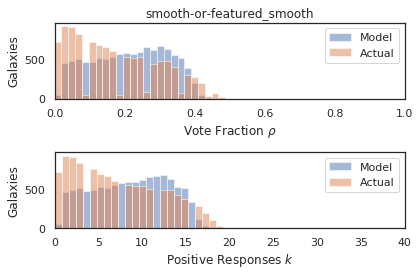

In [91]:

answer = schema.get_answer('smooth-or-featured_smooth')
samples, labels, total_votes = get_single_answer_data(df, answer, n=len(df))
_ = show_population_stats(samples, labels, total_votes, answer.text)

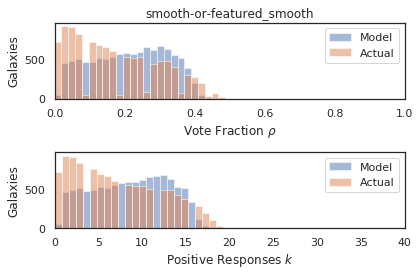

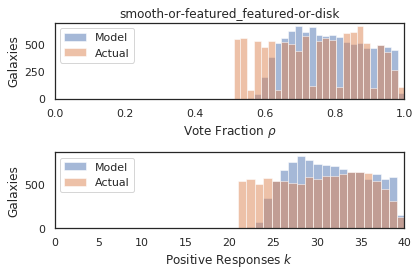

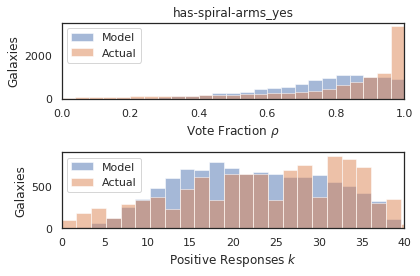

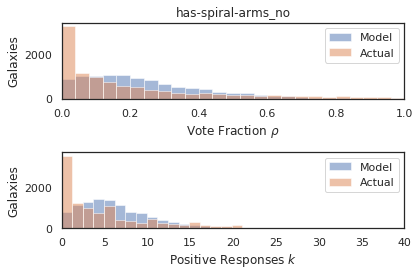

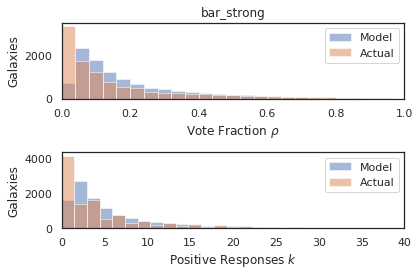

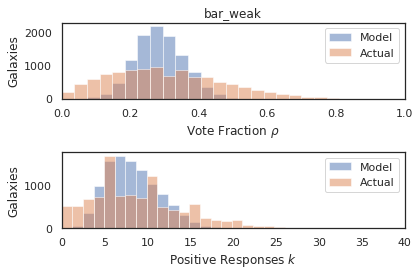

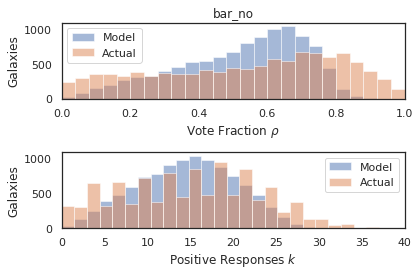

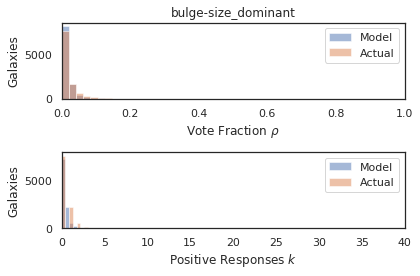

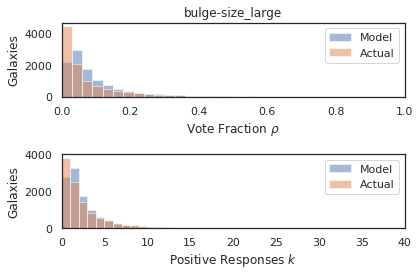

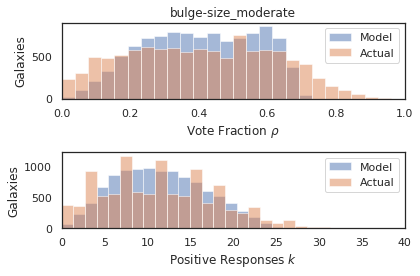

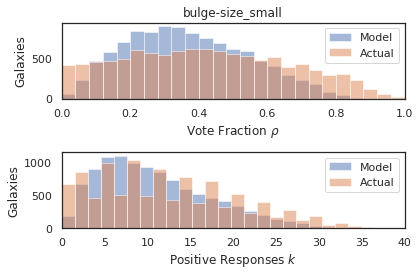

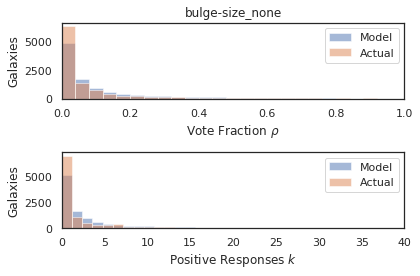

In [92]:
for answer in schema.answers:
    samples, labels, total_votes = get_single_answer_data(df, answer, n=len(df))
    fig = show_population_stats(samples, labels, total_votes, answer.text)
#     fig.savefig(save_dir + '/population_distribution_' + answer.text + '.png')

In [93]:
def custom_samples(samples, labels, total_votes):
    sns.set_context('paper', font_scale=1.5)
    fig, axes = plt.subplots(nrows=len(labels), figsize=(3, len(labels)*1.5), sharex=True)
    make_predictions.plot_samples(samples, labels, total_votes, fig, axes, alpha=0.1)
    for ax in axes:
        ax.set_xlim([0, 40])
    
    for n in range(len(labels)):
#         axes[n].set_ylabel(r'$p(v|D)$', visible=True)
        axes[n].set_ylabel(r'$p(v|w)$', visible=True)
        axes[n].yaxis.set_visible(True)
    
    axes[-1].set_xlabel('Volunteer Votes')
    fig.tight_layout()

    axes[0].legend(
        loc='lower center', 
        bbox_to_anchor=(0.5, 1.1),
        ncol=1, 
        fancybox=True, 
        shadow=False
    )
    fig.tight_layout()
    return fig

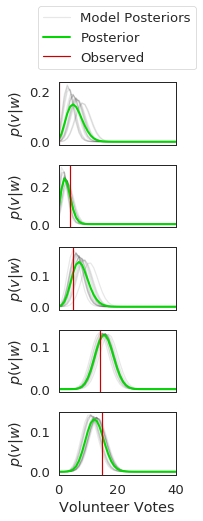

In [94]:

question = schema.get_question('smooth-or-featured')
answer = schema.get_answer(question.text +'_smooth')
n = 5
samples, labels, total_votes = get_single_answer_data(df, answer, n)
_ = custom_samples(samples, labels, total_votes)

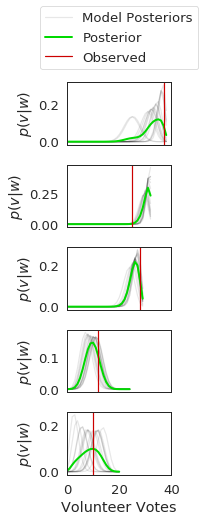

In [95]:

question = schema.get_question('has-spiral-arms')
answer = schema.get_answer(question.text + '_yes')
n = 5
samples, labels, total_votes = get_single_answer_data(df, answer, n)
_ = custom_samples(samples, labels, total_votes)

In [96]:
def plot_galaxy(image_loc, ax, n_examples=10, crop=0):
    im_size = 424
    im = Image.open(image_loc)
#     if QUESTION == 'bars':
#         crop = 120
#     else:
    crop = 35
    cropped_im = im.crop((crop, crop, 424 - crop, 424 - crop))
    ax.imshow(cropped_im)
    ax.grid(False)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)


In [97]:

def galaxy_posterior_grid(df, schema):
    
    sns.set_context('paper', font_scale=1.5)
    
    scale = 1.5
    
    im_width = 2
    posterior_width = 3
    height = im_width
    
    n_galaxies = len(df)
    n_posteriors = len(schema.answers)
    
    fig = plt.figure(figsize=(scale * (im_width + posterior_width*n_posteriors), (scale * n_galaxies * height)))  # width, height format
    gs = gridspec.GridSpec(len(df) * height, im_width + posterior_width * len(schema.answers))  # y, x format
    image_axes = []
    posterior_axes = []  # (galaxy i.e. row, answer) shape
    
    # create the grid
    for galaxy_n in range(len(df)):
        y_slice = slice(galaxy_n*height, (galaxy_n+1)*height)
        image_axes.append(plt.subplot(gs[y_slice, :im_width]))
        
        temp_galaxy_axes = []
        for answer_n, answer in enumerate(schema.answers):
            x_slice = slice(im_width+answer_n*posterior_width, im_width+(answer_n+1)*posterior_width)
            temp_galaxy_axes.append(plt.subplot(gs[y_slice, x_slice]))
        posterior_axes.append(temp_galaxy_axes)
        
    
    # fill the images
    for ax_n, ax in enumerate(image_axes):
        plot_galaxy(df['file_loc'][ax_n], ax)
    
    # fill the posteriors
    for answer_n, answer in enumerate(schema.answers):
        samples, labels, total_votes = get_single_answer_data(df, answer)
        galaxy_axes = [axes[answer_n] for axes in posterior_axes]
        make_predictions.plot_samples(samples, labels, total_votes, fig, galaxy_axes, alpha=0.06)
    
    # fix x limits for comparison
    for row_n, axes in enumerate(posterior_axes):
        for answer_n, ax in enumerate(axes):
            ax.set_xlim([0, 50])
            if row_n == 0:
                ax.set_title(schema.answers[answer_n].text)
    
    fig.tight_layout()
    return fig

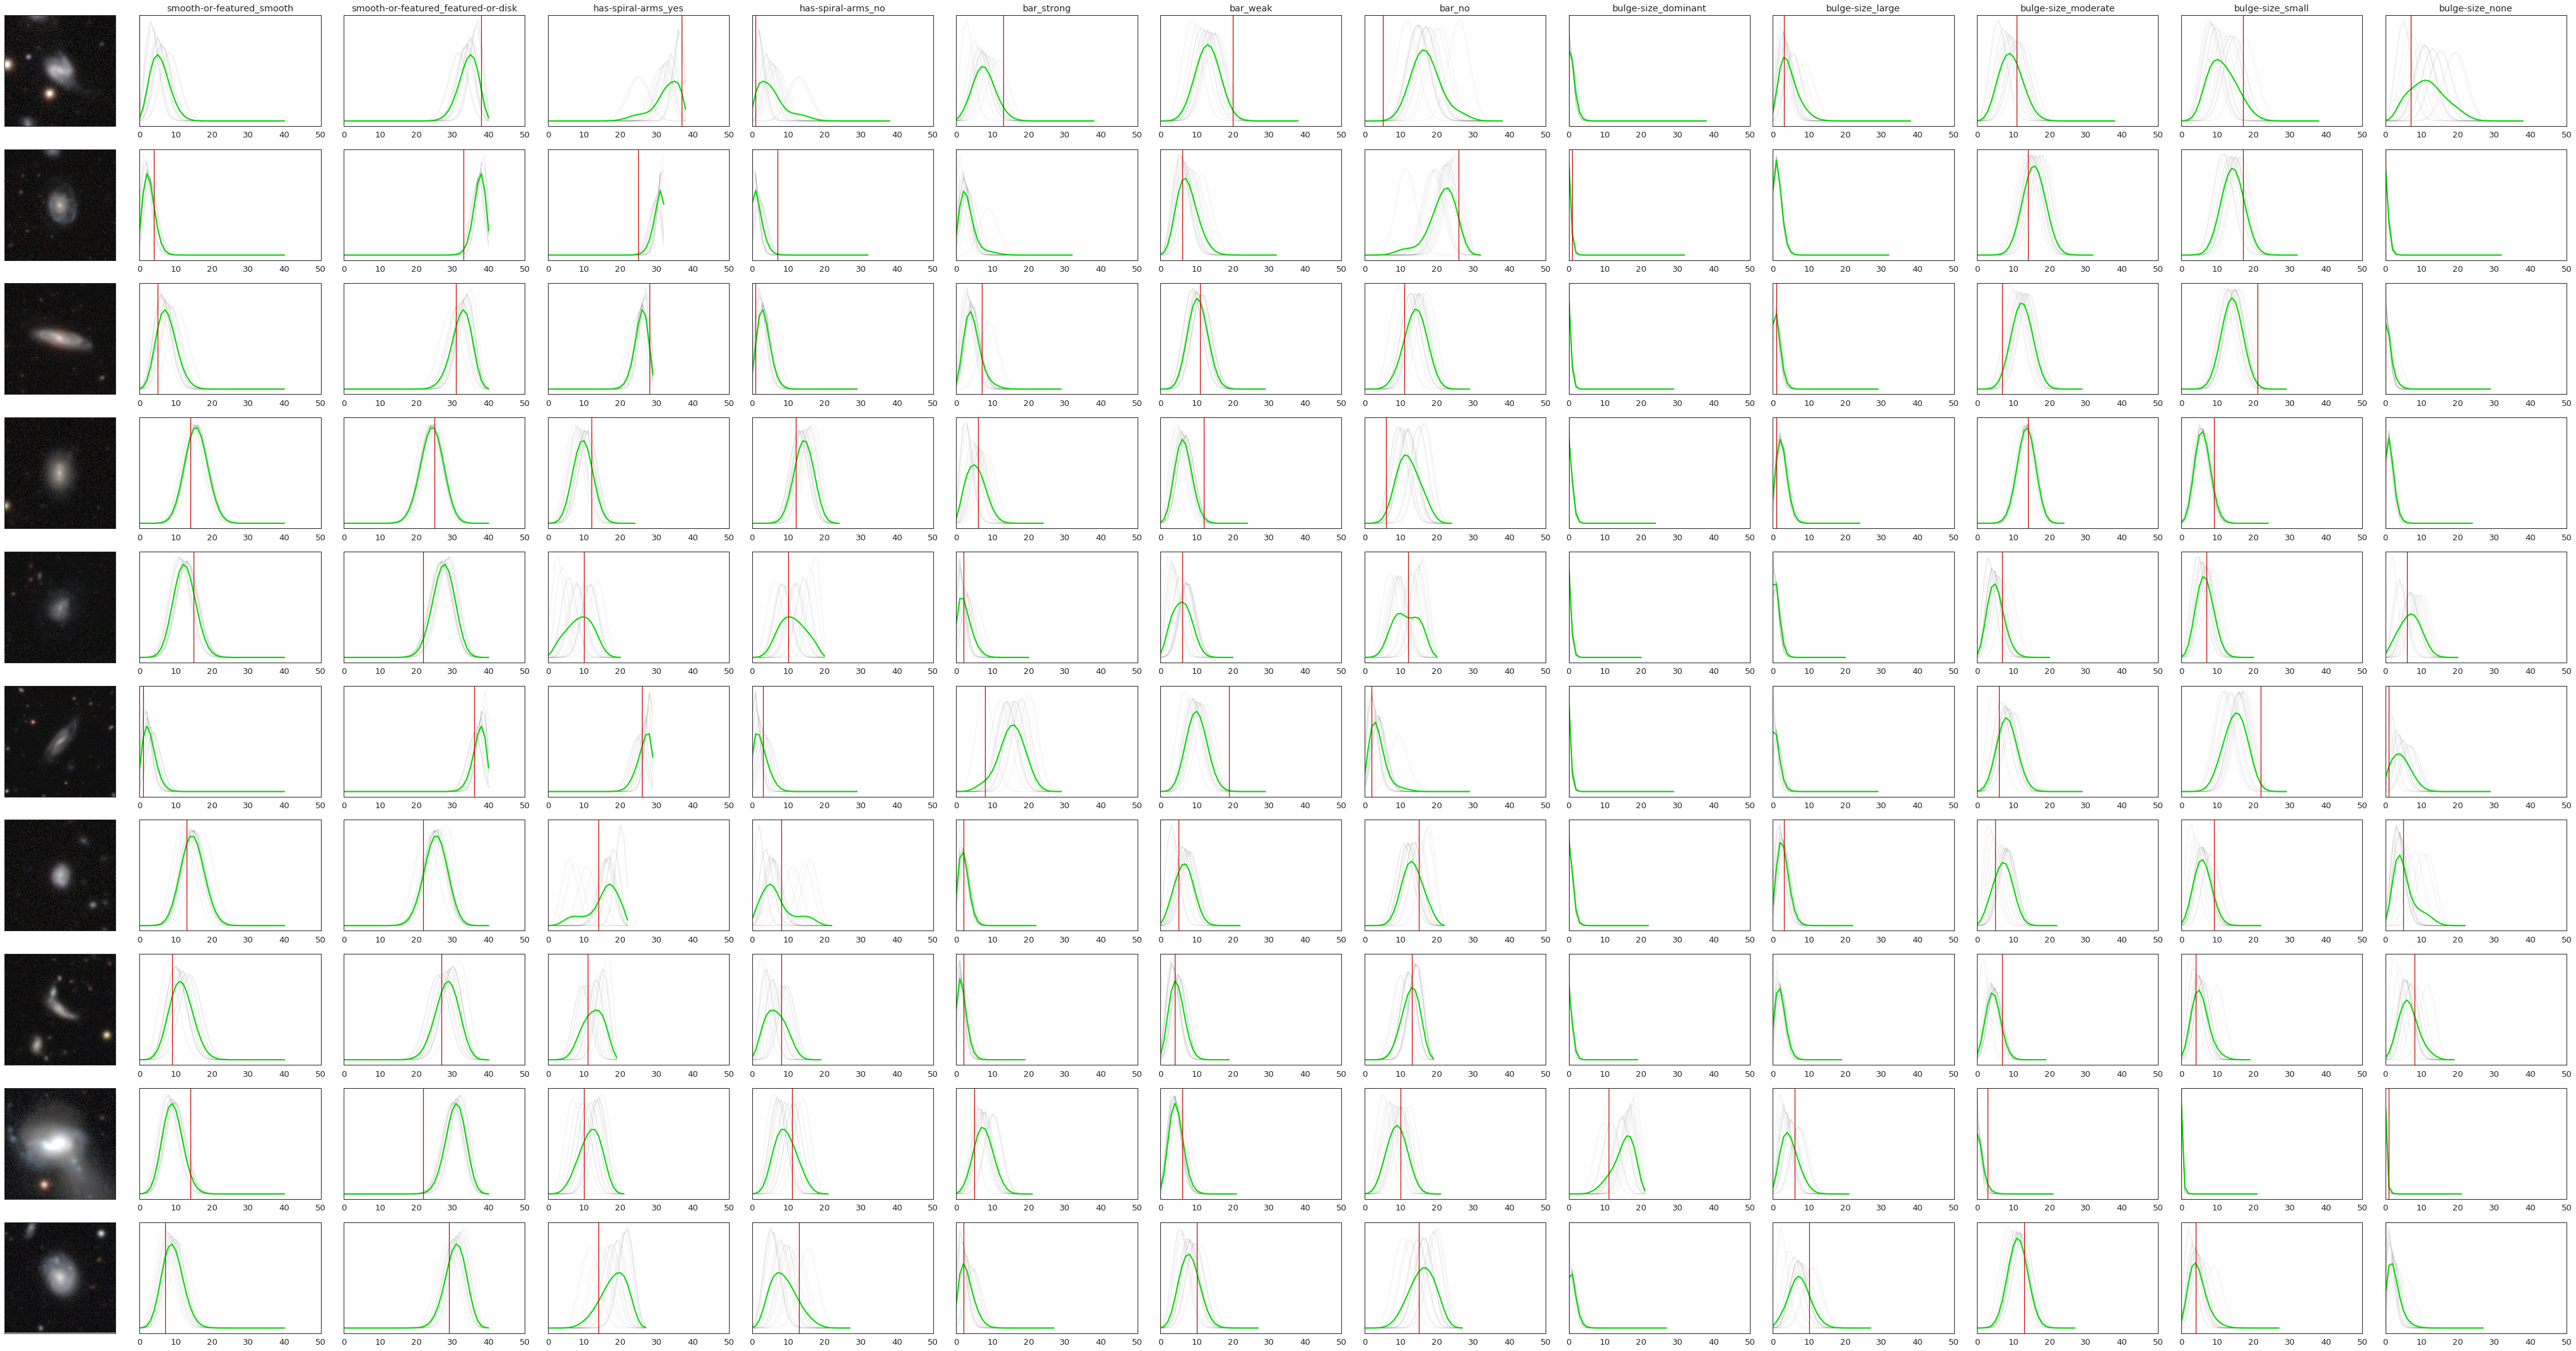

In [98]:
fig = galaxy_posterior_grid(df[:10], schema)
save_dir = 'results'
fig.savefig(save_dir + '/grid.pdf')
fig.savefig(save_dir + '/grid.png')